In [1]:
suppressMessages(library(readr))
suppressMessages(library(DESeq2))
suppressMessages(library(RColorBrewer))
suppressMessages(library(ggplot2))
suppressMessages(library(BiocParallel))
suppressMessages(library(pheatmap))
suppressMessages(library(sva))
suppressMessages(library(reshape2))
suppressMessages(library(edgeR))
suppressMessages(library(cowplot))
suppressMessages(library(riborex))
suppressMessages(library(ggrepel))
suppressMessages(library(fdrtool))
suppressMessages(library(grid))
gene_annotation_file <- '/home/cmb-panasas2/skchoudh/genomes/hg38/annotation/hg38_gene_names_id.tsv'
gene_annotations <- read.table(gene_annotation_file,  header=T, stringsAsFactors = F, 
                               sep='\t')
rownames(gene_annotations) <- gene_annotations$gene_id
'%notin%' <- function(x,y)!('%in%'(x,y))
cbbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

colors <- list(species = c("GRCh38" = cbbPalette[2],
                            "Mmul8" =  cbbPalette[6],
                             "panTro3" =  cbbPalette[7]),
              assay = c("ribo" = cbbPalette[3],
                       "rna" =  cbbPalette[4]))

colors_named <- list(species = c("human" = cbbPalette[2],
                            "macaque" =  cbbPalette[6],
                             "chimpanzee" =  cbbPalette[7]),
              assay = c("ribo" = cbbPalette[3],
                       "rna" =  cbbPalette[4]))

In [2]:
write_results <- function(df, results.dir, prefix){
  df<- as.data.frame(df)
  df <- df[order(df$padj),]
  df$gene_name <- gene_annotations[rownames(df),]$gene_name

  df.sig <- subset(df, padj<0.05)
  df.sig.up <- subset(df.sig, log2FoldChange>0)
  df.sig.down <- subset(df.sig, log2FoldChange<0)
  write.table(df, file = file.path(results.dir,
                                   paste(prefix, 'tsv', sep='.')), sep = '\t')

  write.table(df.sig, file = file.path(results.dir,
                                   paste(prefix, 'sig', 'tsv', sep='.')), sep = '\t')
  write.table(df.sig.up,  file = file.path(results.dir,
                                       paste(prefix, 'sig', 'up', 'tsv', sep='.')), sep = '\t')
  write.table(df.sig.down,  file = file.path(results.dir,
                                         paste(prefix, 'sig', 'down', 'tsv', sep='.')), sep = '\t')
  return (df.sig)
}

In [3]:
plotHeatMap <- function(rlogdist, filename=NULL){
  sampleDists <- dist(t(assay(rlogdist)))
  sampleDistMatrix <- as.matrix(sampleDists)
  rownames(sampleDistMatrix) <- colnames(rlogdist)#paste(rlogdist$condition, colnames(rlogdist), sep="-")
  colnames(sampleDistMatrix) <- NULL
  colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
  pheatmap(sampleDistMatrix,
           clustering_distance_rows=sampleDists,
           cellwidth=10,
           cellheight=10,
          clustering_distance_cols=sampleDists,
           col=colors,)
  if (!is.null(filename)) {
      pheatmap(sampleDistMatrix,
               cellwidth=20,
               cellheight=20,
               clustering_distance_rows=sampleDists,
               clustering_distance_cols=sampleDists,
               col=colors, filename=filename)
  }
}

In [ ]:
metadata <- read.csv('../../re-ribo-smk/data/ortho-datasets-metadata/rna_ribo_metadata.tsv', sep='\t',stringsAsFactors=F)
metadata.ribo <- subset(metadata, metadata$assay=='ribo')
species <- factor(metadata.ribo$species, levels=c("GRCh38", "panTro3", "Mmul8"))
sex <- factor(metadata.ribo$sex, levels=c("female", "male"))

metadata

In [80]:
hg38.Mmul8.ribo.counts <- read.csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds_ribo_ortho_Mmul8.tsv', header=T, row.names=1, stringsAsFactors=F, sep='\t')
hg38.panTro3.ribo.counts <- read.csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds_ribo_ortho_panTro3.tsv', header=T, row.names=1, stringsAsFactors=F, sep='\t')
hg38.all3.ribo.counts <- read.csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds_ribo_ortho_allthree.tsv', header=T, row.names=1, stringsAsFactors=F, sep='\t')

In [81]:
metadata <- read.csv('../../re-ribo-smk/data/ortho-datasets-metadata/rna_ribo_metadata.tsv', sep='\t',stringsAsFactors=F)
metadata.ribo <- subset(metadata, metadata$assay=='ribo')
metadata.ribo

experiment_accession,cell_line,species,sex,assay
SRX1135820,Min18358,panTro3,female,ribo
SRX1135821,Min18358,panTro3,female,ribo
SRX1135822,NS03659,panTro3,female,ribo
SRX1135823,NS04973,panTro3,male,ribo
SRX1135824,Pt91,panTro3,male,ribo
SRX1135825,150-99,Mmul8,female,ribo
SRX1135826,R181-96,Mmul8,male,ribo
SRX1135827,R249-97,Mmul8,male,ribo
SRX1135828,265-95,Mmul8,male,ribo
SRX1135829,R290-96,Mmul8,male,ribo


estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


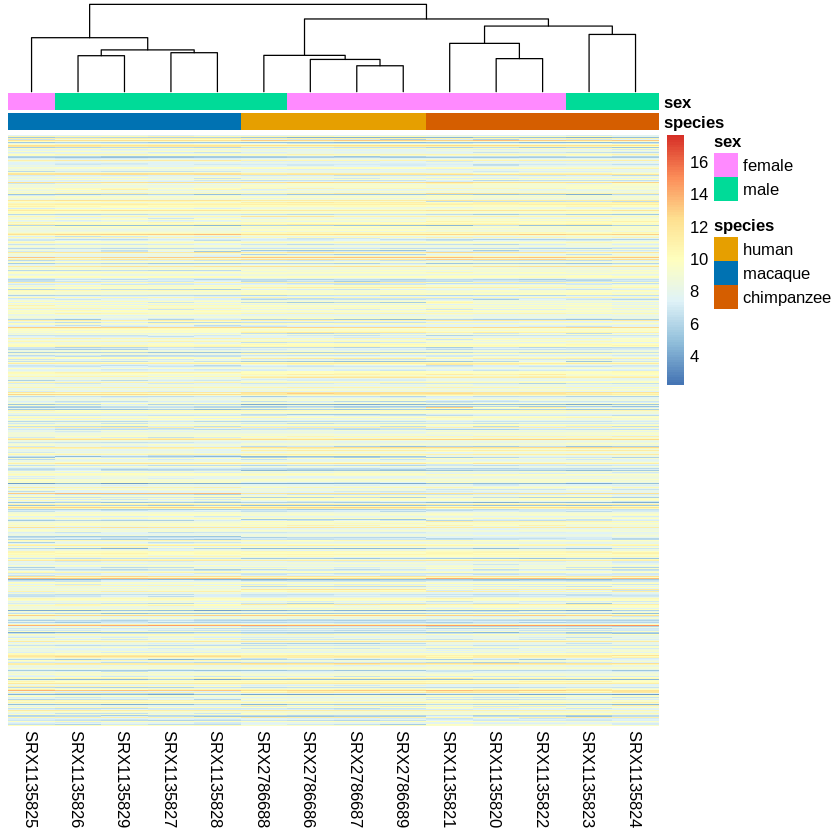

In [119]:
metadata <- read.csv('../../re-ribo-smk/data/ortho-datasets-metadata/rna_ribo_metadata.tsv', sep='\t',stringsAsFactors=F)
metadata.ribo <- subset(metadata, metadata$assay=='ribo')
hg38.all3.ribo.counts <- read.csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds_ribo_ortho_allthree.tsv', header=T, row.names=1, stringsAsFactors=F, sep='\t')
species <- factor(metadata.ribo$species, levels=c("GRCh38", "panTro3", "Mmul8"), labels=c("human", "chimpanzee", "macaque"))
sex <- factor(metadata.ribo$sex, levels=c("female", "male"))

#hg38.Mmul8.ribo.counts <- hg38.Mmul8.ribo.counts[, metadata.ribo$experiment_accession]
#hg38.panTro3.ribo.counts <- hg38.panTro3.ribo.counts[, metadata.ribo$experiment_accession]
hg38.all3.ribo.counts <- hg38.all3.ribo.counts[, metadata.ribo$experiment_accession]

coldata <- data.frame(row.names=colnames(hg38.all3.ribo.counts), species, sex)
dds <- DESeqDataSetFromMatrix(countData=hg38.all3.ribo.counts,
                                    colData=coldata,
                                    design=~species)
dds <- DESeq(dds)
dds <- dds[apply(counts(dds), 1, function(row) all(row !=0 )),]
rld  <- rlogTransformation(dds , blind=TRUE)

annotation.df <- as.data.frame(colData(dds)[, c("species", "sex")])
rownames(annotation.df) <- rownames(colData(dds))
colnames(annotation.df) <- c("species", "sex")
pheatmap(assay(rld), show_rownames = F, cluster_rows = F, annotation_col=annotation.df, annotation_colors = colors_named)
pheatmap(assay(rld), show_rownames = F, cluster_rows = F, annotation_col=annotation.df, annotation_colors = colors_named, file="../../re-ribo-smk/plots/hg38_all3_ribo_cds_counts_heatmap.pdf")

In [120]:
dim(hg38.all3.ribo.counts)

[1] 14479    14

In [121]:
rld$species

[1] chimpanzee chimpanzee chimpanzee chimpanzee chimpanzee macaque   
 [7] macaque    macaque    macaque    macaque    human      human     
[13] human      human     
Levels: human chimpanzee macaque

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


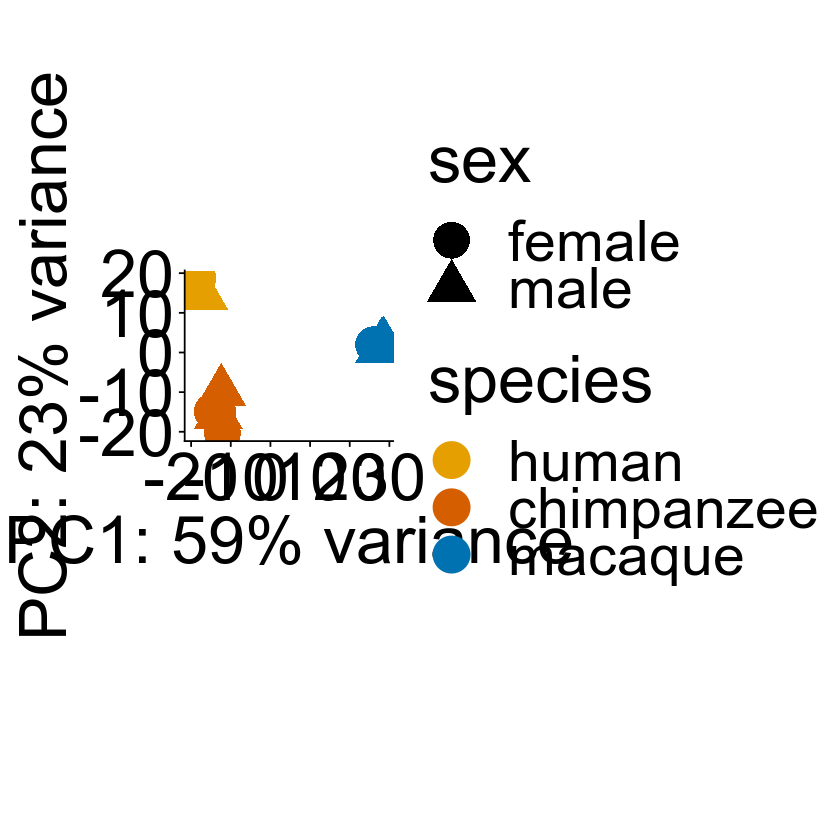

In [9]:
metadata <- read.csv('../../re-ribo-smk/data/ortho-datasets-metadata/rna_ribo_metadata.tsv', sep='\t',stringsAsFactors=F)
metadata.ribo <- subset(metadata, metadata$assay=='ribo')
hg38.all3.ribo.counts <- read.csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds_ribo_ortho_allthree.tsv', header=T, row.names=1, stringsAsFactors=F, sep='\t')
species <- factor(metadata.ribo$species, levels=c("GRCh38", "panTro3", "Mmul8"), labels=c("human", "chimpanzee", "macaque"))
sex <- factor(metadata.ribo$sex, levels=c("female", "male"))

#hg38.Mmul8.ribo.counts <- hg38.Mmul8.ribo.counts[, metadata.ribo$experiment_accession]
#hg38.panTro3.ribo.counts <- hg38.panTro3.ribo.counts[, metadata.ribo$experiment_accession]
hg38.all3.ribo.counts <- hg38.all3.ribo.counts[, metadata.ribo$experiment_accession]

coldata <- data.frame(row.names=colnames(hg38.all3.ribo.counts), species, sex)
dds <- DESeqDataSetFromMatrix(countData=hg38.all3.ribo.counts,
                                    colData=coldata,
                                    design=~species)
dds <- DESeq(dds)
dds <- dds[apply(counts(dds), 1, function(row) all(row !=0 )),]
rld  <- rlogTransformation(dds , blind=TRUE)
data <- plotPCA(rld, intgroup = c("species", "sex"), returnData=TRUE)
percentVar <- round(100 * attr(data, "percentVar"))

ggplot(data, aes(PC1, PC2, color=species, shape=sex, label = rownames(data))) +
      scale_color_manual("species", values=colors_named$species) +
#geom_text_repel() +
geom_point(size=10) +
xlab(paste0("PC1: ",percentVar[1],"% variance")) +
ylab(paste0("PC2: ",percentVar[2],"% variance")) +
coord_fixed() + #ggtitle('PCA -- all samples') +
  theme(text = element_text(size=40), axis.text.x = element_text(size=40), axis.text.y = element_text(size=40))    
ggsave("../../re-ribo-smk/plots/hg38_all3_ribo_cds_counts_pca.pdf", width=10, height=7)
#ggsave('plots_Jan_2019_30C_37C_rna_ribo_de_analysis/heatmap_all.pdf')

# So need to exclude SRX1135820	and 	SRX1135825	 from samples

Contact Pritchard?
Looks wrongly labeled  here: https://www.ncbi.nlm.nih.gov/Traces/study/?acc=SRP062129&go=go

In [104]:
hg38.all3.ribo.counts <- read.csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds_ribo_ortho_allthree.tsv', header=T, row.names=1, stringsAsFactors=F, sep='\t')
hg38.all3.ribo.counts.rm.outlier <- hg38.all3.ribo.counts[, -which(names(hg38.all3.ribo.counts) %in% c("SRX1135825", "SRX1135820"))]
metadata.rm.outlier <- subset(metadata, metadata$experiment_accession %notin% c("SRX1135825", "SRX1135820"))
#metadata
#condition <- factor(metadata$condition, levels=c("30C", "37C"))
#assay <- factor(metadata$assay, levels=c("rna", "ribo"))

species <- factor(metadata.rm.outlier$species, levels=c("GRCh38", "panTro3", "Mmul8"))
sex <- factor(metadata.rm.outlier$sex, levels=c("female", "male"))
coldata <- data.frame(row.names=colnames(hg38.all3.ribo.counts.rm.outlier), species, sex)

dds <- DESeqDataSetFromMatrix(countData=hg38.all3.ribo.counts.rm.outlier,
                                    colData=coldata,
                                    design=~species)
dds <- DESeq(dds)
dds <- dds[apply(counts(dds), 1, function(row) all(row !=0 )),]
rld  <- rlogTransformation(dds , blind=TRUE)
data <- plotPCA(rld, intgroup = c("species", "sex"), returnData=TRUE)
percentVar <- round(100 * attr(data, "percentVar"))

ggplot(data, aes(PC1, PC2, color=species, shape=sex, label = rownames(data))) +
      scale_color_manual("species", values=colors$species) +
geom_text_repel() +
geom_point(size=3) +
xlab(paste0("PC1: ",percentVar[1],"% variance")) +
ylab(paste0("PC2: ",percentVar[2],"% variance")) +
coord_fixed() + #ggtitle('PCA -- all samples') +
  theme(text = element_text(size=12)) 

ERROR: Error in data.frame(row.names = colnames(hg38.all3.ribo.counts.rm.outlier), : row names supplied are of the wrong length


In [ ]:
plotHeatMap(rld)


In [ ]:
pheatmap(assay(rld), show_rownames = F, cluster_rows = F, annotation_col=annotation.df, annotation_colors = colors)

In [ ]:
normalized.counts <- as.data.frame(counts(dds, normalized=T))
write.table(normalized.counts, file='../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds_ribo_ortho_allthree_normalized_counts.tsv', 
          sep='\t', row.names=T)

In [ ]:
resultsNames(dds)

In [ ]:
?results

In [ ]:
results.panTro3 <- results(dds, name='species_panTro3_vs_GRCh38')
results.panTro3 <- as.data.frame(results.panTro3[order(results.panTro3$padj),])

In [ ]:
hist(results.panTro3$pvalue)

In [ ]:
results.Mmul8 <- results(dds, name='species_Mmul8_vs_GRCh38')
results.Mmul8  <- as.data.frame(results.Mmul8 [order(results.Mmul8 $padj),])
hist(results.Mmul8$pvalue)

In [ ]:
dim(results.Mmul8[results.Mmul8$padj<0.01,])

In [ ]:
dim(results.panTro3[results.panTro3$padj<0.01,])

In [ ]:
write_results(results.panTro3, "/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-differential-analysis/", "panTro3_GRCh38_cds_ribo_ortho_allthree")


In [ ]:
write_results(results.Mmul8, "/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-differential-analysis/", "Mmul8_GRCh38_cds_ribo_ortho_allthree")


# uORF

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


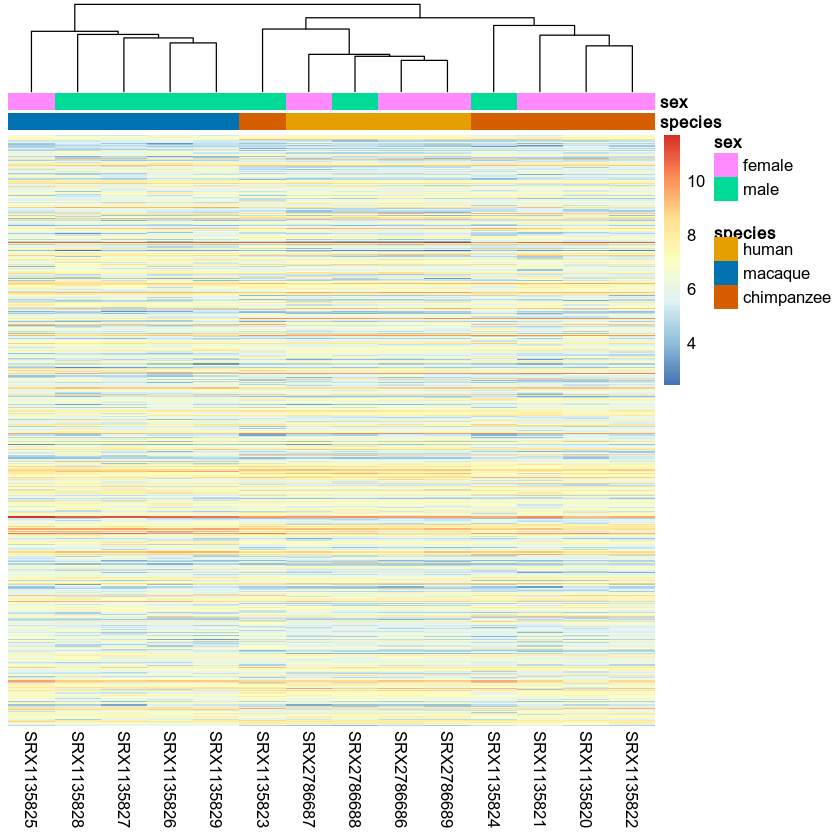

In [8]:
metadata <- read.csv('../../re-ribo-smk/data/ortho-datasets-metadata/rna_ribo_metadata.tsv', sep='\t',stringsAsFactors=F)
metadata.ribo <- subset(metadata, metadata$assay=='ribo')
species <- factor(metadata.ribo$species, levels=c("GRCh38", "panTro3", "Mmul8"), labels=c("human", "chimpanzee", "macaque"))
sex <- factor(metadata.ribo$sex, levels=c("female", "male"))


hg38.Mmul8.ribo.counts <- read.csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_uorf_ribo_ortho_Mmul8.tsv', header=T, row.names=1, stringsAsFactors=F, sep='\t')
hg38.panTro3.ribo.counts <- read.csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_uorf_ribo_ortho_panTro3.tsv', header=T, row.names=1, stringsAsFactors=F, sep='\t')
hg38.all3.ribo.counts <- read.csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_uorf_ribo_ortho_allthree.tsv', header=T, row.names=1, stringsAsFactors=F, sep='\t')
hg38.all3.ribo.counts <- hg38.all3.ribo.counts[, metadata.ribo$experiment_accession]

coldata <- data.frame(row.names=colnames(hg38.all3.ribo.counts), species, sex)
dds <- DESeqDataSetFromMatrix(countData=hg38.all3.ribo.counts,
                              colData=coldata,
                              design=~species)
dds <- DESeq(dds)
dds <- dds[apply(counts(dds), 1, function(row) all(row !=0 )),]
rld  <- rlogTransformation(dds , blind=TRUE)
                 
                 
annotation.df <- as.data.frame(colData(dds)[, c("species", "sex")])
rownames(annotation.df) <- rownames(colData(dds))
colnames(annotation.df) <- c("species", "sex")
pheatmap(assay(rld), show_rownames = F, cluster_rows = F, annotation_col=annotation.df, annotation_colors = colors_named) 
pheatmap(assay(rld), show_rownames = F, cluster_rows = F, annotation_col=annotation.df, annotation_colors = colors_named, file="../../re-ribo-smk/plots/hg38_all3_ribo_uorf_counts_heatmap.pdf")                  
                 
data <- plotPCA(rld, intgroup = c("species", "sex"), returnData=TRUE)
percentVar <- round(100 * attr(data, "percentVar"))

ggplot(data, aes(PC1, PC2, color=species, shape=sex, label = rownames(data))) +
      scale_color_manual("species", values=colors_named$species) +
#geom_text_repel() +
geom_point(size=10) +
xlab(paste0("PC1: ",percentVar[1],"% variance")) +
ylab(paste0("PC2: ",percentVar[2],"% variance")) +
coord_fixed() + #ggtitle('PCA -- all samples') +
  #theme(text = element_text(size=20), axis.text.x = element_text(size=20), axis.text.y = element_text(size=20))   
    theme(text = element_text(size=40), axis.text.x = element_text(size=40), axis.text.y = element_text(size=40))    
ggsave("../../re-ribo-smk/plots/hg38_all3_ribo_uorf_counts_pca.pdf", width=10, height=7)                 

In [ ]:
results.panTro3 <- results(dds, name='species_panTro3_vs_GRCh38')
results.panTro3 <- as.data.frame(results.panTro3[order(results.panTro3$padj),])

In [ ]:
hist(results.panTro3$pvalue)

In [ ]:
results.Mmul8 <- results(dds, name='species_Mmul8_vs_GRCh38')
results.Mmul8  <- as.data.frame(results.Mmul8 [order(results.Mmul8 $padj),])
hist(results.Mmul8$pvalue)

In [ ]:
dim(results.Mmul8[results.Mmul8$padj<0.01,])

In [ ]:
dim(results.panTro3[results.panTro3$padj<0.01,])

In [ ]:
write_results(results.panTro3, 
              "/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-differential-analysis/", 
              "panTro3_GRCh38_uorf_ribo_ortho_allthree")


In [ ]:
write_results(results.Mmul8, 
              "/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-differential-analysis/",
              "Mmul8_GRCh38_uorf_ribo_ortho_allthree")
hist(results.Mmul8$log2FoldChange)

# Translational Efficiency analysis

In [ ]:
metadata <- read.csv('../../re-ribo-smk/data/ortho-datasets-metadata/rna_ribo_metadata.tsv', sep='\t',stringsAsFactors=F)
metadata.rna <- subset(metadata, metadata$assay=='rna')
metadata.ribo <- subset(metadata, metadata$assay=='ribo')

hg38.all3.rna.counts <- read.csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds_rna_ortho_allthree.tsv', header=T, row.names=1, stringsAsFactors=F, sep='\t')
hg38.all3.ribo.counts <- read.csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds_ribo_ortho_allthree.tsv', header=T, row.names=1, stringsAsFactors=F, sep='\t')

hg38.all3.rna.counts <- hg38.all3.rna.counts[, metadata.rna$experiment_accession]
hg38.all3.ribo.counts <- hg38.all3.ribo.counts[, metadata.ribo$experiment_accession]



In [ ]:
common.genes <- intersect(rownames(hg38.all3.rna.counts), rownames(hg38.all3.ribo.counts))
hg38.all3.rna.counts <- hg38.all3.rna.counts[common.genes,]
hg38.all3.ribo.counts <- hg38.all3.ribo.counts[common.genes,]

In [ ]:
hg38.all3.combined.counts <- cbind(hg38.all3.rna.counts, hg38.all3.ribo.counts)
hg38.all3.combined.counts <- hg38.all3.combined.counts[, metadata$experiment_accession]

In [ ]:
species <- factor(metadata$species, levels=c("GRCh38", "panTro3", "Mmul8"))
sex <- factor(metadata$sex, levels=c("female", "male"))
assay <- factor(metadata$assay, levels=c("rna", "ribo"))

coldata <- data.frame(row.names=colnames(hg38.all3.combined.counts), species, sex, assay)
dds <- DESeqDataSetFromMatrix(countData=hg38.all3.combined.counts,
                                    colData=coldata,
                                    design=~species+assay)

dds <- DESeq(dds)
dds <- dds[apply(counts(dds), 1, function(row) all(row !=0 )),]
rld  <- rlogTransformation(dds , blind=TRUE)
annotation.df <- as.data.frame(colData(dds)[, c("species", "sex", "assay")])
rownames(annotation.df) <- rownames(colData(dds))
colnames(annotation.df) <- c("species", "sex", "assay")
pheatmap(assay(rld), show_rownames = F, cluster_rows = F, annotation_col=annotation.df, annotation_colors = colors)                 

In [ ]:
data <- plotPCA(rld, intgroup = c("species", "assay"), returnData=TRUE)
percentVar <- round(100 * attr(data, "percentVar"))

ggplot(data, aes(PC1, PC2, color=species, shape=assay, label = rownames(data))) +
      scale_color_manual("species", values=colors$species) +
geom_text_repel() +
geom_point(size=3) +
xlab(paste0("PC1: ",percentVar[1],"% variance")) +
ylab(paste0("PC2: ",percentVar[2],"% variance")) +
coord_fixed() + #ggtitle('PCA -- all samples') +
  theme(text = element_text(size=12)) 

In [ ]:
rownames(metadata) <- metadata$experiment_accession

In [ ]:
riborex.Mmul8 <- riborex(rnaCntTable = hg38.all3.rna.counts, 
                          riboCntTable = hg38.all3.ribo.counts,
                          rnaCond = data.frame('species' = metadata[colnames(hg38.all3.rna.counts),]$species) ,
                          riboCond = data.frame('species' = metadata[colnames(hg38.all3.ribo.counts),]$species), 
                          contrast = c('species', 'Mmul8', 'GRCh38'), 
                          minMeanCount = 1)
riborex.Mmul8 <- riborex.Mmul8[order(riborex.Mmul8$pvalue),]
riborex.Mmul8 <- as.data.frame(riborex.Mmul8[order(riborex.Mmul8$pvalue),])

In [ ]:
hist(riborex.Mmul8$pvalue)

In [ ]:
dim(riborex.Mmul8[riborex.Mmul8$pvalue<0.05,])

In [ ]:
riborex.panTro3 <- riborex(rnaCntTable = hg38.all3.rna.counts, 
                          riboCntTable = hg38.all3.ribo.counts,
                          rnaCond = data.frame('species' = metadata[colnames(hg38.all3.rna.counts),]$species) ,
                          riboCond = data.frame('species' = metadata[colnames(hg38.all3.ribo.counts),]$species), 
                          contrast = c('species', 'panTro3', 'GRCh38'), 
                          minMeanCount = 1)
riborex.panTro3 <- riborex.panTro3[order(riborex.panTro3$pvalue),]
riborex.panTro3 <- as.data.frame(riborex.panTro3[order(riborex.panTro3$pvalue),])
hist(riborex.panTro3$pvalue)

In [ ]:
dim(riborex.panTro3[riborex.panTro3$pvalue<0.05,])

In [ ]:
write_results(riborex.panTro3,
              "/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-differential-analysis/", 
              "panTro3_GRCh38_TE_ortho_allthree")
write_results(riborex.Mmul8, 
              "/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-differential-analysis/", 
              "Mmul8_GRCh38_TE_ortho_allthree")


In [ ]:
metadata.hg38 = subset(metadata, metadata$species == 'GRCh38')
sex <- factor(metadata.hg38$sex, levels=c("male", "female"))
assay <- factor(metadata.hg38$assay, levels=c("rna", "ribo"))

hg38.cds.counts <- read.csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds.tsv', sep='\t', row.names=1)
hg38.cds.counts <- hg38.cds.counts[, metadata.hg38$experiment_accession]


In [ ]:
coldata <- data.frame(row.names=colnames(hg38.cds.counts), sex, assay)
dds <- DESeqDataSetFromMatrix(countData=hg38.cds.counts,
                              colData=coldata,
                              design=~assay)
dds <- DESeq(dds)
dds <- dds[apply(counts(dds), 1, function(row) all(row !=0 )),]
rld  <- rlogTransformation(dds , blind=TRUE)
                 
                 
annotation.df <- as.data.frame(colData(dds)[, c("assay", "sex")])
rownames(annotation.df) <- rownames(colData(dds))
colnames(annotation.df) <- c("assay", "sex")
pheatmap(assay(rld), show_rownames = F, cluster_rows = F, annotation_col=annotation.df, annotation_colors = colors) 
                 
data <- plotPCA(rld, intgroup = c("assay", "sex"), returnData=TRUE)
percentVar <- round(100 * attr(data, "percentVar"))

ggplot(data, aes(PC1, PC2, color=assay, shape=sex, label = rownames(data))) +
      scale_color_manual("assay", values=colors$assay) +
geom_text_repel() +
geom_point(size=3) +
xlab(paste0("PC1: ",percentVar[1],"% variance")) +
ylab(paste0("PC2: ",percentVar[2],"% variance")) +
coord_fixed() + #ggtitle('PCA -- all samples') +
  theme(text = element_text(size=12))      

In [ ]:
results.hg38.TE <- results(dds)
write_results(results.hg38.TE,
              "/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-datasets-translational-efficiency/", 
              "GRCh38_TE")


In [ ]:
hg38.uORF.counts <- read.csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_uORF.tsv', sep='\t', row.names=1)
hg38.uORF.counts <- hg38.uORF.counts[, metadata.hg38$experiment_accession]

coldata <- data.frame(row.names=colnames(hg38.uORF.counts), sex, assay)
dds <- DESeqDataSetFromMatrix(countData=hg38.uORF.counts,
                              colData=coldata,
                              design=~assay)
dds <- DESeq(dds)
dds <- dds[apply(counts(dds), 1, function(row) all(row !=0 )),]
rld  <- rlogTransformation(dds , blind=TRUE)
                 
                 
annotation.df <- as.data.frame(colData(dds)[, c("assay", "sex")])
rownames(annotation.df) <- rownames(colData(dds))
colnames(annotation.df) <- c("assay", "sex")
pheatmap(assay(rld), show_rownames = F, cluster_rows = F, annotation_col=annotation.df, annotation_colors = colors) 
                 
data <- plotPCA(rld, intgroup = c("assay", "sex"), returnData=TRUE)
percentVar <- round(100 * attr(data, "percentVar"))

ggplot(data, aes(PC1, PC2, color=assay, shape=sex, label = rownames(data))) +
      scale_color_manual("assay", values=colors$assay) +
geom_text_repel() +
geom_point(size=3) +
xlab(paste0("PC1: ",percentVar[1],"% variance")) +
ylab(paste0("PC2: ",percentVar[2],"% variance")) +
coord_fixed() + #ggtitle('PCA -- all samples') +
  theme(text = element_text(size=12))      

In [ ]:
results.hg38.dORF <- results(dds)
write_results(results.hg38.dORF,
              "/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-datasets-translational-efficiency/", 
              "GRCh38_dORF")
